In [26]:
import glob
import os
import numpy as np
import gzip
import torch
import pickle
import sys
import json
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath('..'))
from brush_stroke import BrushStroke

In [132]:
cache_dir = '../caches/vae_sharpie_final'
canvases_before_fns = glob.glob(os.path.join(cache_dir, 'stroke_library', 'canvases_before_*.npy'))
canvases_after_fns = glob.glob(os.path.join(cache_dir, 'stroke_library', 'canvases_after_*.npy'))
brush_strokes_fns = glob.glob(os.path.join(cache_dir, 'stroke_library', 'stroke_parameters*.npy'))

# Ensure each of the files is in the order they were recorded in
canvases_before_fns = sorted(canvases_before_fns)
canvases_after_fns = sorted(canvases_after_fns)
brush_strokes_fns = sorted(brush_strokes_fns)

# canvases_before_fns = canvases_before_fns[:5]
# canvases_after_fns = canvases_after_fns[:5]
# brush_strokes_fns = brush_strokes_fns[:5]

# Load data
canvases_before = None
for canvases_before_fn in canvases_before_fns:
    with gzip.GzipFile(canvases_before_fn,'r') as f:
        s = np.load(f, allow_pickle=True).astype(np.float32)/255.
        canvases_before = s if canvases_before is None else np.concatenate([canvases_before, s])

canvases_after = None
for canvases_after_fn in canvases_after_fns:
    with gzip.GzipFile(canvases_after_fn,'r') as f:
        s = np.load(f, allow_pickle=True).astype(np.float32)/255.
        canvases_after = s if canvases_after is None else np.concatenate([canvases_after, s])

brush_strokes = []
for brush_strokes_fn in brush_strokes_fns:
    bs = pickle.load(open(brush_strokes_fn,'rb'))
    brush_strokes = bs if brush_strokes is None else np.concatenate([brush_strokes, bs]) 
for b in brush_strokes:
    b.vae_name = os.path.join('..', b.vae_name)

canvases_before = torch.from_numpy(canvases_before).float().nan_to_num()
canvases_after = torch.from_numpy(canvases_after).float().nan_to_num()

with open(os.path.join(cache_dir, 'stroke_library', 'stroke_settings_during_library.json'), 'r') as f:
    settings = json.load(f)
    CANVAS_WIDTH_M = settings['CANVAS_WIDTH_M']
    CANVAS_HEIGHT_M = settings['CANVAS_HEIGHT_M']

paths = []
for b in brush_strokes:
    path = b.get_path()[:,:2]
    path = torch.flip(path, dims=(1,)) 
    path[:, 0] *= -1
    path[:, 0] /= CANVAS_HEIGHT_M
    path[:, 1] /= CANVAS_WIDTH_M
    path[:, 0] += b.yt
    path[:, 1] += b.xt
    paths.append(path.detach())
paths = torch.stack(paths, dim=0)

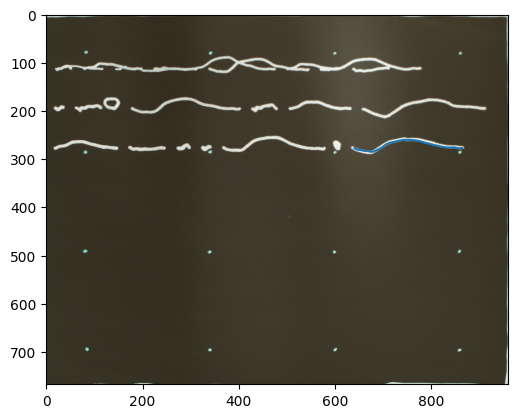

In [154]:
idx = 18
h, w, _ = canvases_after[idx].shape
path = paths[idx]
path = torch.flip(path, dims=(1,)) 
# plot the path
plt.plot(path[:, 0]*w, path[:, 1]*h)
plt.imshow(canvases_after[idx])